In [4]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bids import BIDSLayout
from multiprocessing.pool import Pool
from functools import partial
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import copy
import os
from sklearn.metrics import mean_squared_error

In [5]:
locations_tsv_layout = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate = False)

In [6]:
locations_tsv_layout.get_subjects()

['104', '081', '079', '078', '097', '086', '090', '084']

In [7]:
locations_tsv_files = locations_tsv_layout.get(extension='tsv', suffix='space', return_type='filename')

In [8]:
locations_tsv_files[0:10]

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-004/ieeg/sub-078_ses-004_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-005/ieeg/sub-078_ses-005_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-006/ieeg/sub-078_ses-006_task-full_run-02_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-007/ieeg/sub-078_ses-007_task-full_run-02_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-010/ieeg/sub-078_ses-010_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scra

In [9]:
edf_files_layout = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate=False)

In [10]:
edf_files_layout.get_subjects()

['104', '081', '079', '078', '097', '086', '090', '084']

In [11]:
edf_files = edf_files_layout.get(extension='edf', suffix='clean', return_type='filename')
edf_files[0:10]

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-004/ieeg/sub-078_ses-004_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-005/ieeg/sub-078_ses-005_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-006/ieeg/sub-078_ses-006_task-full_run-02_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-007/ieeg/sub-078_ses-007_task-full_run-02_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-010/ieeg/sub-078_ses-010_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-011/ieeg/sub-078_ses-011_task-full_run-01_clean.edf',


In [9]:
df_test = pd.read_csv(locations_tsv_files[0], sep='\t')
df_test.head()

,type,label,x,y,z,group,Label ID,Label,R,G,B
0,SEEGA,LAHc1-2,-21.0290,16.5070,31.532,LAHc,17,Left-Hippocampus,220,216,20
1,SEEGA,LAHc2-3,-25.7220,16.5770,33.091,LAHc,17,Left-Hippocampus,220,216,20
2,SEEGA,LAHc3-4,-30.4895,16.6175,34.273,LAHc,17,Left-Hippocampus,220,216,20
3,SEEGA,LAHc4-5,-35.2850,16.7270,35.260,LAHc,2,Left-Cerebral-White-Matter,245,245,245
4,SEEGA,LAHc5-6,-40.1380,16.7135,36.183,LAHc,2,Left-Cerebral-White-Matter,245,245,245


In [10]:
df_test['Region']=df_test['Label'].str.replace('Left-', '')
df_test['Region']=df_test['Region'].str.replace('Right-', '')
df_test

,type,label,x,y,z,group,Label ID,Label,R,G,B,Region
0,SEEGA,LAHc1-2,-21.0290,16.5070,31.5320,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
1,SEEGA,LAHc2-3,-25.7220,16.5770,33.0910,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
2,SEEGA,LAHc3-4,-30.4895,16.6175,34.2730,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
3,SEEGA,LAHc4-5,-35.2850,16.7270,35.2600,LAHc,2,Left-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter
4,SEEGA,LAHc5-6,-40.1380,16.7135,36.1830,LAHc,2,Left-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter
...,...,...,...,...,...,...,...,...,...,...,...,...
103,SEEGA,RLOcLg5-6,30.5915,-27.0690,46.7875,RLOcLg,41,Right-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter
104,SEEGA,RLOcLg6-7,33.5495,-30.7380,47.7140,RLOcLg,41,Right-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter
105,SEEGA,RLOcLg7-8,36.3515,-34.5695,48.4290,RLOcLg,41,Right-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter
106,SEEGA,RLOcLg8-9,39.4170,-38.3700,49.4085,RLOcLg,41,Right-Cerebral-White-Matter,245,245,245,Cerebral-White-Matter


In [11]:
non_white_matter_unknown_bool = df_test['Label'].str.contains('White-Matter|Unknown', case=False, regex=True)==False
filtered_df = df_test.loc[non_white_matter_unknown_bool]
filtered_df.head()

,type,label,x,y,z,group,Label ID,Label,R,G,B,Region
0,SEEGA,LAHc1-2,-21.0290,16.5070,31.5320,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
1,SEEGA,LAHc2-3,-25.7220,16.5770,33.0910,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
2,SEEGA,LAHc3-4,-30.4895,16.6175,34.2730,LAHc,17,Left-Hippocampus,220,216,20,Hippocampus
18,SEEGA,LAOFr1-2,-9.4585,54.7580,18.2755,LAOFr,1014,ctx-lh-medialorbitofrontal,200,35,75,ctx-lh-medialorbitofrontal
19,SEEGA,LAOFr2-3,-13.7695,56.6895,19.5540,LAOFr,1012,ctx-lh-lateralorbitofrontal,35,75,50,ctx-lh-lateralorbitofrontal


In [12]:
unique_labels = set(filtered_df['Label'].str.replace('Left-', '').str.replace('Right-', ''))
unique_labels

{'Amygdala',
 'Hippocampus',
 'ctx-lh-insula',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-parstriangularis',
 'ctx-lh-superiortemporal',
 'ctx-rh-lingual'}

In [13]:
regions_dict = {}
for label in unique_labels:
    if label in regions_dict.keys():
        regions_dict[label] = regions_dict[label]+filtered_df[filtered_df['Region']==label].index.values.tolist()
    else:
        regions_dict[label] = filtered_df.loc[filtered_df['Region']==label,'label'].values.tolist()

In [14]:
regions_dict

{'ctx-lh-insula': ['LMIn1-2',
  'LMIn2-3',
  'LMIn3-4',
  'LMIn4-5',
  'LPIn1-2',
  'LPIn2-3',
  'LPIn3-4',
  'LPIn4-5',
  'LPIn9-10'],
 'ctx-rh-lingual': ['RLOcLg1-2'],
 'ctx-lh-lateralorbitofrontal': ['LAOFr2-3',
  'LAOFr3-4',
  'LAOFr4-5',
  'LAOFr5-6',
  'LPOFrL2-3'],
 'ctx-lh-parstriangularis': ['LPOFrL8-9'],
 'Amygdala': ['LAm2-3', 'LAm3-4'],
 'ctx-lh-superiortemporal': ['LAm4-5', 'LAm8-9'],
 'Hippocampus': ['LAHc1-2',
  'LAHc2-3',
  'LAHc3-4',
  'LMHc1-2',
  'LMHc2-3',
  'LMHc3-4',
  'RAHc1-2',
  'RAHc2-3',
  'RAHc3-4'],
 'ctx-lh-medialorbitofrontal': ['LAOFr1-2', 'LPOFrL1-2'],
 'ctx-lh-middletemporal': ['LAm9-10', 'LMHc8-9', 'LMHc9-10']}

In [25]:
signals_region.keys()

dict_keys(['Amygdala'])

In [26]:
len(signals_region['Amygdala'])

215

In [12]:
def welchMethod(data, srate):
    # create Hann window
    winsize = int( 2.0*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.01; # Hz
    nfft = int(srate/spectres)
    # print('hihi')
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    # print(welchpow.shape)
    # Normalizing
    if welchpow.ndim > 1:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))
    else:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2)))
    return f, welchpow

In [103]:
def extract_channel_data(chn_label, edf_file):
    edf_in = pyedflib.EdfReader(edf_file)
    # Get labels from original edf file
    channels_labels = edf_in.getSignalLabels()
    # Get channel id
    chn_id = channels_labels.index(chn_label)
    # Get the data
    signal = edf_in.readSignal(chn_id)
    edf_in.close()
    f, psd = welchMethod(signal, 200)
    return f, psd, chn_label

In [14]:
def plotAllChannels(freq, welchpow, out_path=None, output=False, show_fig = False):
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    fig, ax = plt.subplots()
    ax.semilogx(freq,welchpow)
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    if output:
        fig.savefig(out_path)
    if show_fig:
        plt.show()
    else:
        plt.close()

In [90]:
def plotPaperFigures(freq, welchpow, out_path=None, output=False, show_fig=False):
    # welchpow: n_chans x n_samples
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get std
    n_samples = welchpow.shape[1]
    std = np.zeros(n_samples)
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
    # Get quartiles
    quant = np.quantile(welchpow, [0.25, 0.75], axis=0)
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))

    fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    quant[0,:],
                    quant[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    # ax.set_xscale('log')
    if output:
        fig.savefig(out_path)
    if show_fig:
        plt.show()
    else:
        plt.close()
    return median_welchpow, mean, std

In [104]:
%%time
# Loop over files and extract info
psd_region = {}
f_regions = {}
edf_regions = {}
chn_regions = {}
for tsv, edf in zip(locations_tsv_files, edf_files):
    # Read location tsv file
    df_locations = pd.read_csv(tsv, sep='\t')
    # Add new column with the regions
    df_locations['Region']=df_locations['Label'].str.replace('Left-', '')
    df_locations['Region']=df_locations['Region'].str.replace('Right-', '')
    # Filter white-matter and unknown 
    non_white_matter_unknown_bool = df_locations['Label'].str.contains('White-Matter|Unknown', case=False, regex=True)==False
    filtered_df = df_locations.loc[non_white_matter_unknown_bool]
    # Get unique regions
    unique_labels = set(filtered_df['Region'])
    # unique_labels = ['Amygdala'] # REMOVE
    # Get regions info in dict
    for label in unique_labels:
        # Get channel labels associated to region label
        chn_list = filtered_df.loc[filtered_df['Region']==label,'label'].values.tolist()
        # Get data from edf file
        # ctx = get_context('spawn')
        with Pool(processes=4) as pool:
            # signals = pool.map(partial(extract_channel_data, edf_file=edf), chn_list)
            f, psd, chns = zip(*pool.map(partial(extract_channel_data, edf_file=edf), chn_list))
        # Convert signals to frequency domain
        # data = np.vstack(signals)
        # f, psd = welchMethod(data, 200)
        # Append to dictionary
        if label in psd_region.keys():
            psd_region[label] += psd
            edf_regions[label]+= [edf for curve in psd]
            chn_regions[label] += chns 
            f_regions[label] += f
        else:
            psd_region[label] = psd
            edf_regions[label] = [edf for curve in psd]
            chn_regions[label] = chns 
            f_regions[label] = f
        

CPU times: user 8.81 s, sys: 2min 14s, total: 2min 23s
Wall time: 7min 12s


--Welch for every label after each iteration:
CPU times: user 5min 40s, sys: 4min 22s, total: 10min 3s
Wall time: 11min 2s

--Welch on every signal
CPU times: user 8.26 s, sys: 54.7 s, total: 1min 2s
Wall time: 5min 12s

In [13]:
len(psd_region.keys())

40

In [14]:
len(edf_regions.keys())

40

In [91]:
out_dir = '/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD'
median_region = {}
std_region = {}
mean_region = {}
for region in psd_region.keys():
    # Extract data
    psd = np.vstack(psd_region[region])
    f = np.vstack(f_regions[region])
    # Save arrays
    # np.save(os.path.join(out_dir,f'numpy_arrays/{region}_psd.npy'), psd)
    # np.save(os.path.join(out_dir,f'numpy_arrays/{region}_f.npy'), f)
    # Plot and save all channels
    output_path = os.path.join(out_dir,f'{region}_allChan.png')
    plotAllChannels(f.T, psd.T, output_path)
    # Plot and save the median curve
    output_path = os.path.join(out_dir,f'{region}_distribution.png')
    median, mean, std = plotPaperFigures(f[0], psd, output_path)
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean

In [16]:
psd = np.vstack(psd_region['Amygdala'])
f = np.vstack(f_regions['Amygdala'])

In [57]:
f.shape

(215, 10001)

In [50]:
psd.shape

(215, 10001)

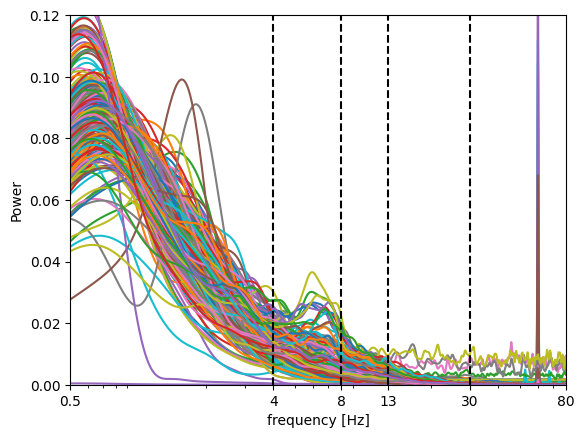

In [21]:
plotAllChannels(f.T, psd.T, show_fig=True)

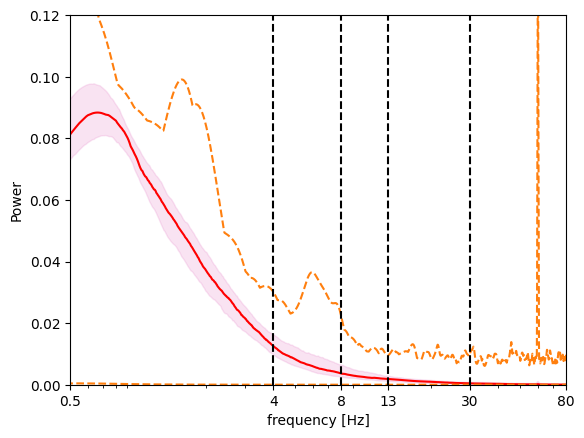

array([1.44995142e-02, 2.90367809e-02, 2.91499247e-02, ...,
       2.60398167e-06, 2.60309500e-06, 1.30139974e-06])

In [22]:
plotPaperFigures(f[0], psd, show_fig=True)


In [ ]:
del f, welchpow, data

## Compare against original

In [74]:
# Original data
# edf_files_layout2 = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/work', validate=False)
edf_files_layout2 = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate=False)

In [75]:
edf_files2 = edf_files_layout2.get(subject= '079',extension='edf', suffix='clean', return_type='filename')
edf_files2

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-002/ieeg/sub-079_ses-002_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-003/ieeg/sub-079_ses-003_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-004/ieeg/sub-079_ses-004_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-005/ieeg/sub-079_ses-005_task-full_run-01_clean.edf']

In [76]:
# Loop over files and extract info
signals_region = {}
for edf in edf_files2:
    label = 'ctx-rh-parstriangularis'
    # Get channel labels associated to region label
    # chn_list = ['RPOFr9', 'RPOFr10']
    chn_list = ['RPOFr9-10']
    # Get data from edf file
    with Pool(processes=4) as pool:
        signals = pool.map(partial(extract_channel_data, edf_file=edf), chn_list)
    # Append to dictionary
    if label in signals_region.keys():
        # signals_region[label] += [signals[0]-signals[1]]
        signals_region[label] += signals
    else:
        # signals_region[label] = [signals[0]-signals[1]]
        signals_region[label] = signals

In [77]:
data = np.vstack(signals_region['ctx-rh-parstriangularis'])

In [78]:
data.shape

(4, 60200)

In [79]:
f, welchpow = welchMethod(data, 200)

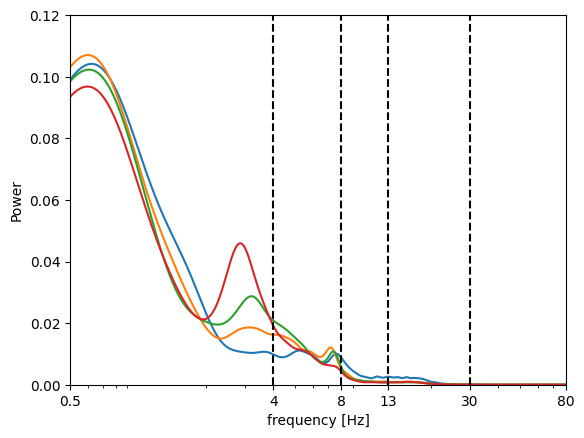

In [80]:
plotAllChannels(f, welchpow)

## Calculate error against median

In [97]:
def error_std(mean, std, y_pred):
    # Center signal
    y_centered = np.subtract(y_pred, mean)
    return np.sum(np.abs(np.divide(y_centered, std, out=np.zeros_like(y_pred), where=std!=0)))/len(std)

In [105]:
# Using the RMSE
rmse_regions_list = []
for region in psd_region.keys():
    # Extract data per signal
    for idx, psd in enumerate(psd_region[region]):
        # print(region)
        # Calculate error per freq band
        freq_bands = [0,4,8,13,30,80]
        rmse_bands = []
        for i in range(len(freq_bands)-1):
            idx0 = np.argmin(np.abs(f_regions[region][idx]-freq_bands[i]))
            idx1 = np.argmin(np.abs(f_regions[region][idx]-freq_bands[i+1]))
            rmse_bands.append(error_std(mean_region[region][idx0:idx1], std_region[region][idx0:idx1], psd[idx0:idx1].squeeze()))
        tmp_dict = {
            'Region': region,
            'Index list': idx,
            'EDF file': edf_regions[region][idx],
            'Channel': chn_regions[region][idx],
            'Error Delta': np.round(rmse_bands[0], decimals=4),
            'Error Theta': np.round(rmse_bands[1], decimals=4),
            'Error Alpha': np.round(rmse_bands[2], decimals=4),
            'Error Beta': np.round(rmse_bands[3], decimals=4),
            'Error Gamma': np.round(rmse_bands[4], decimals=4)
        }
        rmse_regions_list.append(tmp_dict)

In [106]:
rmse_regions_df = pd.DataFrame(rmse_regions_list)
rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']

,Region,Index list,EDF file,Channel,Error Delta,Error Theta,Error Alpha,Error Beta,Error Gamma
752,Amygdala,0,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,LAm2-3,0.7699,0.1232,0.1554,0.2313,0.3577
753,Amygdala,1,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,LAm3-4,0.2787,0.1153,0.1191,0.0783,0.2086
754,Amygdala,2,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,LAm2-3,0.7996,0.7372,0.3597,0.1357,0.2327
755,Amygdala,3,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,LAm3-4,0.1923,0.1299,0.1855,0.2657,0.4984
756,Amygdala,4,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,LAm2-3,1.0764,0.4392,0.1913,0.1071,0.2410
...,...,...,...,...,...,...,...,...,...
962,Amygdala,210,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,RAm4-5,0.5782,1.3206,0.5804,0.2294,0.3853
963,Amygdala,211,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,RAm1-2,0.6399,1.1332,1.8909,0.4787,0.3344
964,Amygdala,212,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,RAm2-3,0.5776,2.3841,2.6869,0.5593,0.3315
965,Amygdala,213,/home/mcesped/scratch/code/sEEGPrep/Results/ru...,RAm3-4,1.1017,0.1915,0.5137,0.1354,0.2319


In [107]:
rmse_regions_df.iloc[rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']['Error Delta'].idxmax()]

Region                                                  Amygdala
Index list                                                   164
EDF file       /home/mcesped/scratch/code/sEEGPrep/Results/ru...
Channel                                                   RAm3-4
Error Delta                                               4.0428
Error Theta                                               1.5807
Error Alpha                                               1.2775
Error Beta                                                0.9735
Error Gamma                                               0.6883
Name: 916, dtype: object

In [102]:
rmse_regions_df.iloc[rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']['Error Delta'].idxmax()]['EDF file']

'/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-097/ses-019/ieeg/sub-097_ses-019_task-full_run-01_clean.edf'

In [77]:
rmse_regions_df.to_csv(os.path.join(out_dir, 'error_regions.tsv'), sep='\t')

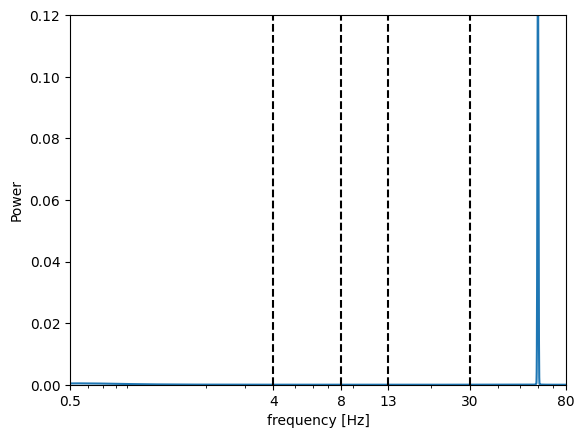

In [101]:
# Test
plotAllChannels(f_regions['Amygdala'][16],psd_region['Amygdala'][164], show_fig=True)